# Exploration
In this notebook some visualizations are made to find some trends in the data. The final goal is to predict the remaining time of a trace.

In [28]:
# import basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import pm4py library to work with XES logs and process mining
import pm4py

In [2]:
log = pm4py.read_xes("data/BPI_Challenge_2017.xes.gz")
log_df = pm4py.convert_to_dataframe(log)
log_df.head()

d:\Users\annik\anaconda3\lib\site-packages\pm4py\util\dt_parsing\parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Filter incomplete cases
At this point, we are not exactly sure yet what it means to be 'complete', so we filter out the least occuring end activities

In [4]:
start_activities = pm4py.get_start_activities(log)
end_activities = pm4py.get_end_activities(log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'A_Create Application': 31509}
End activities: {'W_Validate application': 12662, 'W_Call after offers': 9457, 'W_Call incomplete files': 4676, 'O_Cancelled': 4436, 'W_Complete application': 144, 'W_Assess potential fraud': 102, 'O_Sent (mail and online)': 15, 'O_Sent (online only)': 8, 'W_Shortened completion ': 5, 'W_Personal Loan collection': 2, 'A_Denied': 1, 'O_Returned': 1}


In [15]:
# override end_activities to only contain most occuring
end_activities = ['W_Validate application', 'W_Call after offers', 'W_Call incomplete files', 'O_Cancelled']

# filter out
filtered_log = pm4py.filter_end_activities(log, end_activities)
end_activities = pm4py.get_end_activities(filtered_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'A_Create Application': 31509}
End activities: {'W_Validate application': 12662, 'W_Call after offers': 9457, 'W_Call incomplete files': 4676, 'O_Cancelled': 4436}


## Calculate the remaining time
For each activity, calculate it's place in the trace. For instance first activity, second activity, etc. Add this feature to the dataframe. Then, calculate the remaining time from each activity till the last activity in the trace. We also add this as feature to the dataframe

In [16]:
filtered_log_df = pm4py.convert_to_dataframe(filtered_log)

# add column "event_index_in_trace"
# which indicates the 1st, 2nd ... event in the trace
filtered_log_df.loc[:,"event_index_in_trace"] = filtered_log_df.groupby("case:concept:name").cumcount()

# add column "remain_time" 
# which indicates time from that event until the last event in the trace
filtered_log_df.loc[:,"time:timestamp"] = pd.to_datetime(filtered_log_df["time:timestamp"], utc=True)
filtered_log_df.loc[:,"remain_time"] = filtered_log_df.groupby("case:concept:name")["time:timestamp"].apply(lambda x: x.max() - x).values
filtered_log_df.loc[:,"remain_time"] = filtered_log_df["remain_time"].dt.total_seconds() / (24 * 60 * 60)  # convert to float days
filtered_log_df.head()

C:\Users\annik\AppData\Local\Temp\ipykernel_16404\621199276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log_df.loc[:,"event_index_in_trace"] = filtered_log_df.groupby("case:concept:name").cumcount()
C:\Users\annik\AppData\Local\Temp\ipykernel_16404\621199276.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log_df.loc[:,"time:timestamp"] = pd.to_datetime(filtered_log_df["time:timestamp"], utc=True)
C:\Users\annik\AppData\Local\Temp\ipykernel_16404\621199276.py:10: SettingWithCopy

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,event_index_in_trace,remain_time
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,13.248566
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,13.248566
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,13.248561
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,13.247628
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,13.247628


## Visualizations
Visualize the remaining time against the place an activity has in the trace. Logically, we'd expect lower indices (i.e. activities that happen early) to have more remaining time. Additionally, we experiment with coloring the dots in the scatterplot using different features to visually look for correlation.

<AxesSubplot:xlabel='event_index_in_trace', ylabel='remain_time'>

d:\Users\annik\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


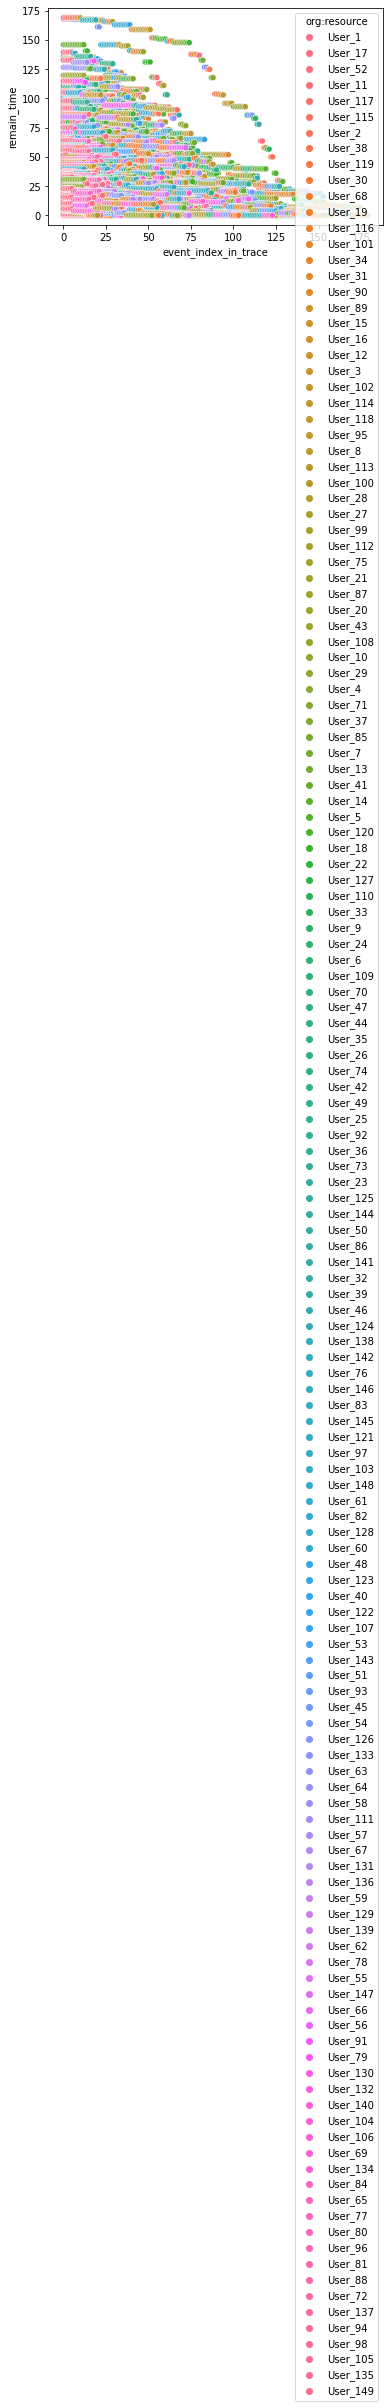

In [21]:
sns.scatterplot(data=filtered_log_df, x='event_index_in_trace', y='remain_time', hue='org:resource')

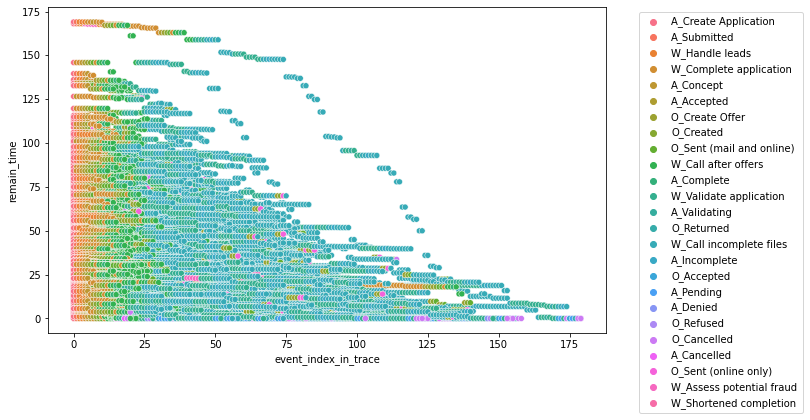

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_log_df, x='event_index_in_trace', y='remain_time', hue='concept:name')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<AxesSubplot:xlabel='event_index_in_trace', ylabel='remain_time'>

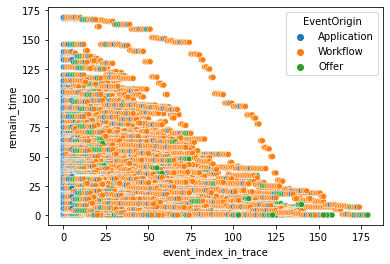

In [23]:
sns.scatterplot(data=filtered_log_df, x='event_index_in_trace', y='remain_time', hue='EventOrigin')

<AxesSubplot:xlabel='event_index_in_trace', ylabel='remain_time'>

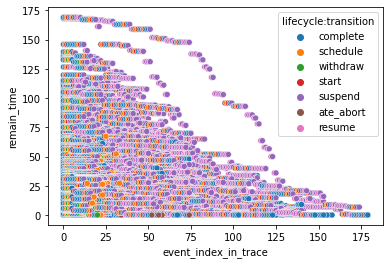

In [24]:
sns.scatterplot(data=filtered_log_df, x='event_index_in_trace', y='remain_time', hue='lifecycle:transition')

<AxesSubplot:xlabel='event_index_in_trace', ylabel='remain_time'>

d:\Users\annik\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


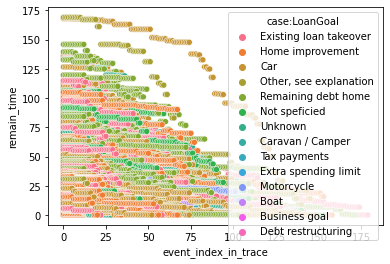

In [25]:
sns.scatterplot(data=filtered_log_df, x='event_index_in_trace', y='remain_time', hue='case:LoanGoal')

<AxesSubplot:xlabel='event_index_in_trace', ylabel='remain_time'>

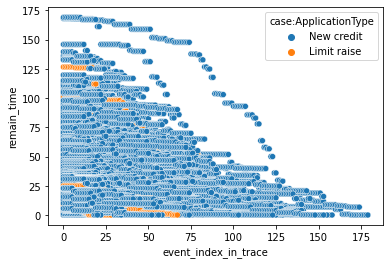

In [26]:
sns.scatterplot(data=filtered_log_df, x='event_index_in_trace', y='remain_time', hue='case:ApplicationType')

## Findings
Prefix length seems to give us a good upperbound on the remaining time. There seems to be a solid triangle with one line above there, that has a longer remaining time. Which seems to be loan goal: car. Let's filter it out and see what happens

In [33]:
no_car_df = filtered_log_df[filtered_log_df['case:LoanGoal'] != 'Car'].copy()
only_car_df = filtered_log_df[filtered_log_df['case:LoanGoal'] == 'Car'].copy()

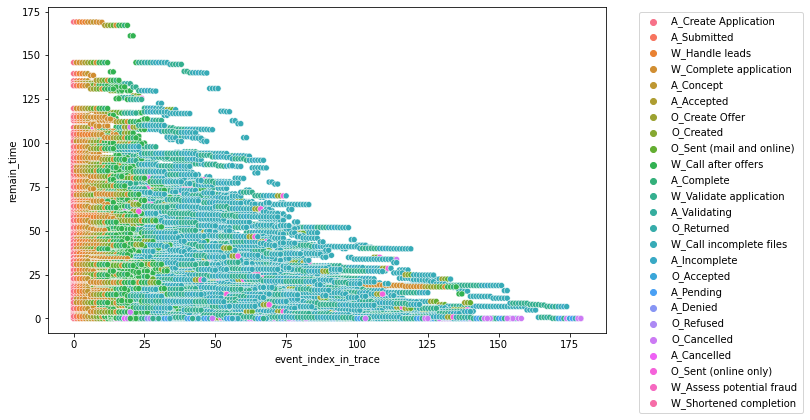

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=no_car_df, x='event_index_in_trace', y='remain_time', hue='concept:name')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

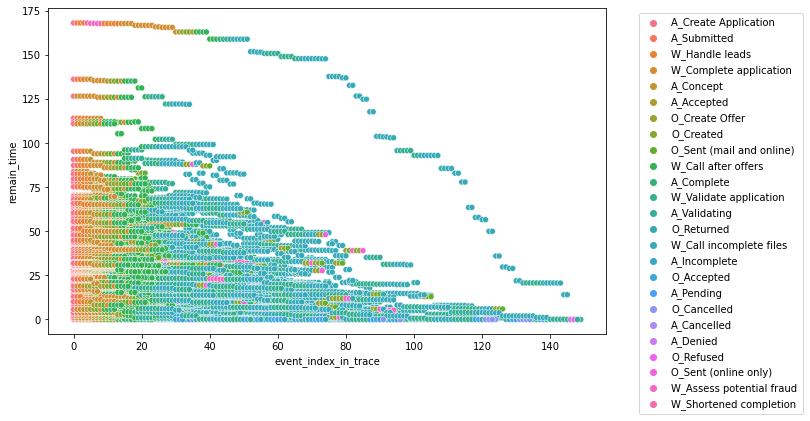

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=only_car_df, x='event_index_in_trace', y='remain_time', hue='concept:name')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()